In [161]:
import numpy as np
import matplotlib.pyplot as plt
# import warnings
# warnings.filterwarnings('ignore')

In [162]:
def initialize_membership_matrix(num_samples, num_clusters):
    membership_mat = np.random.rand(num_clusters, num_samples)
    membership_mat /= np.sum(membership_mat, axis=0)
    return membership_mat

def initial_centroids(num_clusters, num_features):
    return np.random.rand(num_clusters, num_features)
    

In [163]:
def epsilon_insensitive_loss(y_true, y_pred, epsilon):
    # Calculate absolute errors
    errors = np.abs(y_true - y_pred)
    # Apply epsilon-insensitive penalty
    loss = np.maximum(0, errors - epsilon)
    return np.mean(loss)

In [164]:
def update_membership_matrix(data, centroids, num_clusters, epsilon, m):
    # Update the membership matrix
    num_samples = data.shape[0]
    membership_mat = np.zeros((num_clusters, num_samples)).astype('float128')
    for i in range(num_samples):
        denominator = np.sum(epsilon_insensitive_loss(data[i], centroids, epsilon)**(1/(1-m))) 
        for k in range(num_clusters):
            membership_mat[k, i] = (epsilon_insensitive_loss(data[i], centroids[k], epsilon) ** (1/(1-m))) / (denominator + 1e-8)
            if np.isinf(membership_mat[k, i]):
                membership_mat[k, i] = 1
    membership_mat /= np.sum(membership_mat, axis=0)
    return membership_mat

In [165]:
from scipy.optimize import minimize


EPSILON = .01
DATA = None
L    = None


def objective(x):
    global EPSILON 
    global DATA
    global L
    a = x[:len(x)//2]
    b = x[len(x)//2:]
    temp = 0
    for k in range(len(a)):
        temp += (a[k] - b[k])*DATA[k,L]
    return temp + sum(a + b) * EPSILON

def constraint(x):
    a = x[:len(x)//2]
    b = x[len(x)//2:]
    return sum(a) - sum(b)

def Lambda(num_samples, membership_mat, i_index, m):
    initial_guess = [0.] * num_samples*2
    bounds_a = [(0, membership_mat[i_index, j]**m) for j in range(num_samples)]
    bounds_b = [(0, membership_mat[i_index, j]**m) for j in range(num_samples)]
    bounds = np.concatenate((bounds_a, bounds_b))
    constraint_eq = {'type': 'eq', 'fun': constraint}
    result = minimize(objective, initial_guess, bounds=bounds, constraints=constraint_eq, method='SLSQP')

    return result.x[:len(result.x)//2], result.x[len(result.x)//2:]

def update_centroid(data, num_samples, num_features, num_clusters, centroids, epsilon, membership_mat, m, alpah):
    global EPSILON, DATA, L
    EPSILON = epsilon
    DATA = data
    for i in range(num_clusters):
        for j in range(num_features):
            L = j
            l1, l2 = Lambda(num_samples, membership_mat, i, m)
            f, s = 0., 0.
            for ns in range(num_samples):
                if 0<l1[ns]<membership_mat[i, ns]:
                    f += data[ns][j] + epsilon
                if 0<l2[ns]<membership_mat[i, ns]:
                    s += data[ns][j] - epsilon
            # print(f, end=":")
            # print(s)
            centroids[i][j] = alpah * (f+s) / np.unique(np.concatenate((l1, l2))).shape[0] + (1-alpah) * centroids[i][j]
    
    return centroids
        

In [166]:
from sklearn.metrics import normalized_mutual_info_score

def fuzzy_cmeans(data, num_clusters, max_iter, epsilon, m, y=None, alpha=.5):
    history_mem, history_cent, history_nmi = [], [], []
    num_samples, num_features = data.shape
    cen_mat = initial_centroids(num_clusters, num_features)
    for _ in range(max_iter):
        print(_, end=':')
        mem_mat = update_membership_matrix(data, cen_mat, num_clusters, epsilon, m)
        cen_mat = update_centroid(data, num_samples, num_features, num_clusters, cen_mat, epsilon, mem_mat, m, alpah=.5)
        if y is not None:
            max_membership_cluster = np.argmax(mem_mat, axis=0)
            nmi = normalized_mutual_info_score(y, max_membership_cluster)
            history_mem.append(mem_mat)
            history_cent.append(cen_mat)
            history_nmi.append(nmi)
            # if nmi > .9:
            #     return cen_mat, mem_mat
            print("Normalized Mutual Information (NMI):", nmi)
    
    max_index = np.argmax(history_nmi)
    print(cen_mat)
    print(mem_mat)
    return history_cent[max_index], history_mem[max_index]
        

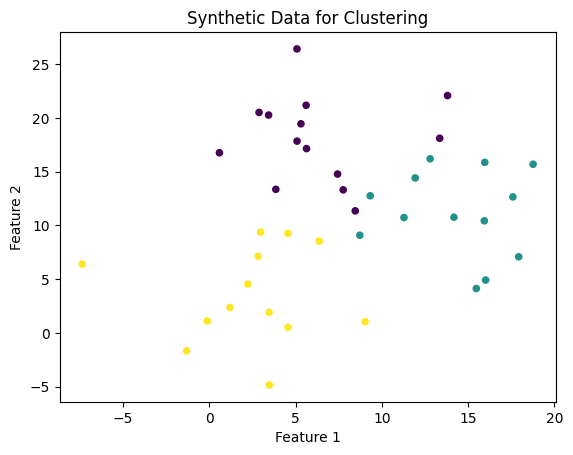

0:

/tmp/ipykernel_7809/3481851007.py:8: RuntimeWarning: divide by zero encountered in scalar power
  membership_mat[k, i] = (epsilon_insensitive_loss(data[i], centroids[k], epsilon) ** (1/(1-m))) / (denominator + 1e-8)


Normalized Mutual Information (NMI): 0.1286270532086794
1:Normalized Mutual Information (NMI): 0.32956754771499586
2:

/tmp/ipykernel_7809/3481851007.py:6: RuntimeWarning: divide by zero encountered in scalar power
  denominator = np.sum(epsilon_insensitive_loss(data[i], centroids, epsilon)**(1/(1-m)))
/tmp/ipykernel_7809/3481851007.py:8: RuntimeWarning: divide by zero encountered in scalar power
  membership_mat[k, i] = (epsilon_insensitive_loss(data[i], centroids[k], epsilon) ** (1/(1-m))) / (denominator + 1e-8)
/tmp/ipykernel_7809/3481851007.py:8: RuntimeWarning: invalid value encountered in scalar divide
  membership_mat[k, i] = (epsilon_insensitive_loss(data[i], centroids[k], epsilon) ** (1/(1-m))) / (denominator + 1e-8)


Normalized Mutual Information (NMI): 0.5018243044413268
3:

/tmp/ipykernel_7809/3481851007.py:6: RuntimeWarning: divide by zero encountered in scalar power
  denominator = np.sum(epsilon_insensitive_loss(data[i], centroids, epsilon)**(1/(1-m)))
/tmp/ipykernel_7809/3481851007.py:8: RuntimeWarning: divide by zero encountered in scalar power
  membership_mat[k, i] = (epsilon_insensitive_loss(data[i], centroids[k], epsilon) ** (1/(1-m))) / (denominator + 1e-8)
/tmp/ipykernel_7809/3481851007.py:8: RuntimeWarning: invalid value encountered in scalar divide
  membership_mat[k, i] = (epsilon_insensitive_loss(data[i], centroids[k], epsilon) ** (1/(1-m))) / (denominator + 1e-8)


Normalized Mutual Information (NMI): 0.6005133421518671
4:Normalized Mutual Information (NMI): 0.437033346749649
5:Normalized Mutual Information (NMI): 0.6404572766181806
6:

/tmp/ipykernel_7809/3481851007.py:8: RuntimeWarning: divide by zero encountered in scalar power
  membership_mat[k, i] = (epsilon_insensitive_loss(data[i], centroids[k], epsilon) ** (1/(1-m))) / (denominator + 1e-8)


Normalized Mutual Information (NMI): 0.4898395666958091
7:

/tmp/ipykernel_7809/3481851007.py:6: RuntimeWarning: divide by zero encountered in scalar power
  denominator = np.sum(epsilon_insensitive_loss(data[i], centroids, epsilon)**(1/(1-m)))
/tmp/ipykernel_7809/3481851007.py:8: RuntimeWarning: divide by zero encountered in scalar power
  membership_mat[k, i] = (epsilon_insensitive_loss(data[i], centroids[k], epsilon) ** (1/(1-m))) / (denominator + 1e-8)
/tmp/ipykernel_7809/3481851007.py:8: RuntimeWarning: invalid value encountered in scalar divide
  membership_mat[k, i] = (epsilon_insensitive_loss(data[i], centroids[k], epsilon) ** (1/(1-m))) / (denominator + 1e-8)


Normalized Mutual Information (NMI): 0.6741782723106622
8:Normalized Mutual Information (NMI): 0.6031560771352453
9:

/tmp/ipykernel_7809/3481851007.py:6: RuntimeWarning: divide by zero encountered in scalar power
  denominator = np.sum(epsilon_insensitive_loss(data[i], centroids, epsilon)**(1/(1-m)))
/tmp/ipykernel_7809/3481851007.py:8: RuntimeWarning: divide by zero encountered in scalar power
  membership_mat[k, i] = (epsilon_insensitive_loss(data[i], centroids[k], epsilon) ** (1/(1-m))) / (denominator + 1e-8)
/tmp/ipykernel_7809/3481851007.py:8: RuntimeWarning: invalid value encountered in scalar divide
  membership_mat[k, i] = (epsilon_insensitive_loss(data[i], centroids[k], epsilon) ** (1/(1-m))) / (denominator + 1e-8)


Normalized Mutual Information (NMI): 0.5968540328557185
10:

/tmp/ipykernel_7809/3481851007.py:8: RuntimeWarning: divide by zero encountered in scalar power
  membership_mat[k, i] = (epsilon_insensitive_loss(data[i], centroids[k], epsilon) ** (1/(1-m))) / (denominator + 1e-8)


Normalized Mutual Information (NMI): 0.6834543840784485
11:

/tmp/ipykernel_7809/3481851007.py:6: RuntimeWarning: divide by zero encountered in scalar power
  denominator = np.sum(epsilon_insensitive_loss(data[i], centroids, epsilon)**(1/(1-m)))
/tmp/ipykernel_7809/3481851007.py:8: RuntimeWarning: divide by zero encountered in scalar power
  membership_mat[k, i] = (epsilon_insensitive_loss(data[i], centroids[k], epsilon) ** (1/(1-m))) / (denominator + 1e-8)
/tmp/ipykernel_7809/3481851007.py:8: RuntimeWarning: invalid value encountered in scalar divide
  membership_mat[k, i] = (epsilon_insensitive_loss(data[i], centroids[k], epsilon) ** (1/(1-m))) / (denominator + 1e-8)


Normalized Mutual Information (NMI): 0.6741782723106622
12:Normalized Mutual Information (NMI): 0.5407780067798014
13:

/tmp/ipykernel_7809/3481851007.py:6: RuntimeWarning: divide by zero encountered in scalar power
  denominator = np.sum(epsilon_insensitive_loss(data[i], centroids, epsilon)**(1/(1-m)))
/tmp/ipykernel_7809/3481851007.py:8: RuntimeWarning: divide by zero encountered in scalar power
  membership_mat[k, i] = (epsilon_insensitive_loss(data[i], centroids[k], epsilon) ** (1/(1-m))) / (denominator + 1e-8)
/tmp/ipykernel_7809/3481851007.py:8: RuntimeWarning: invalid value encountered in scalar divide
  membership_mat[k, i] = (epsilon_insensitive_loss(data[i], centroids[k], epsilon) ** (1/(1-m))) / (denominator + 1e-8)


Normalized Mutual Information (NMI): 0.44432855399579424
14:

/tmp/ipykernel_7809/3481851007.py:8: RuntimeWarning: divide by zero encountered in scalar power
  membership_mat[k, i] = (epsilon_insensitive_loss(data[i], centroids[k], epsilon) ** (1/(1-m))) / (denominator + 1e-8)


Normalized Mutual Information (NMI): 0.4197414742197238
15:

/tmp/ipykernel_7809/3481851007.py:6: RuntimeWarning: divide by zero encountered in scalar power
  denominator = np.sum(epsilon_insensitive_loss(data[i], centroids, epsilon)**(1/(1-m)))
/tmp/ipykernel_7809/3481851007.py:8: RuntimeWarning: divide by zero encountered in scalar power
  membership_mat[k, i] = (epsilon_insensitive_loss(data[i], centroids[k], epsilon) ** (1/(1-m))) / (denominator + 1e-8)
/tmp/ipykernel_7809/3481851007.py:8: RuntimeWarning: invalid value encountered in scalar divide
  membership_mat[k, i] = (epsilon_insensitive_loss(data[i], centroids[k], epsilon) ** (1/(1-m))) / (denominator + 1e-8)


Normalized Mutual Information (NMI): 0.5968540328557185
16:Normalized Mutual Information (NMI): 0.5407780067798014
17:

/tmp/ipykernel_7809/3481851007.py:6: RuntimeWarning: divide by zero encountered in scalar power
  denominator = np.sum(epsilon_insensitive_loss(data[i], centroids, epsilon)**(1/(1-m)))
/tmp/ipykernel_7809/3481851007.py:8: RuntimeWarning: divide by zero encountered in scalar power
  membership_mat[k, i] = (epsilon_insensitive_loss(data[i], centroids[k], epsilon) ** (1/(1-m))) / (denominator + 1e-8)
/tmp/ipykernel_7809/3481851007.py:8: RuntimeWarning: invalid value encountered in scalar divide
  membership_mat[k, i] = (epsilon_insensitive_loss(data[i], centroids[k], epsilon) ** (1/(1-m))) / (denominator + 1e-8)


Normalized Mutual Information (NMI): 0.63147067547324
18:

/tmp/ipykernel_7809/3481851007.py:8: RuntimeWarning: divide by zero encountered in scalar power
  membership_mat[k, i] = (epsilon_insensitive_loss(data[i], centroids[k], epsilon) ** (1/(1-m))) / (denominator + 1e-8)


Normalized Mutual Information (NMI): 0.7040313737239762
19:

/tmp/ipykernel_7809/3481851007.py:6: RuntimeWarning: divide by zero encountered in scalar power
  denominator = np.sum(epsilon_insensitive_loss(data[i], centroids, epsilon)**(1/(1-m)))
/tmp/ipykernel_7809/3481851007.py:8: RuntimeWarning: divide by zero encountered in scalar power
  membership_mat[k, i] = (epsilon_insensitive_loss(data[i], centroids[k], epsilon) ** (1/(1-m))) / (denominator + 1e-8)
/tmp/ipykernel_7809/3481851007.py:8: RuntimeWarning: invalid value encountered in scalar divide
  membership_mat[k, i] = (epsilon_insensitive_loss(data[i], centroids[k], epsilon) ** (1/(1-m))) / (denominator + 1e-8)
/media/mrj/documents/AI/MachineLearning/.venv/lib/python3.10/site-packages/scipy/optimize/_slsqp_py.py:437: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  fx = wrapped_fun(x)
/media/mrj/documents/AI/MachineLearning/.venv/lib/python3.10/site-packages/scipy/optimize/_slsqp_py.py:441: RuntimeWarning: Values in x were outside bounds during

Normalized Mutual Information (NMI): 0.5057486928579711
[[ 7.42896307 10.80255298]
 [ 7.43423445 10.61429802]
 [ 7.47518261 10.73425277]]
[[0.33589709 0.27204069 0.32380755 0.33796971 0.30664902 0.3251024
         nan 0.3358151  0.31910158 0.3265404  0.34815452 0.32999867
  0.32696449 0.32814069 0.33585501 0.35305941 0.32925606 0.33078662
  0.32606015 0.33647907 0.34356186 0.32536449 0.26777186 0.33070871
  0.3396764  0.32631353 0.33952822 0.33706122 0.32823259 0.33747405
  0.32020486 0.32768761 0.33738694 0.32980413 0.35456266 0.29756703
  0.34051428 0.33884135 0.32952298 0.32897732]
 [0.35358404 0.21649997 0.30888487 0.34717833 0.25816402 0.31196601
         nan 0.35277884 0.29819119 0.33917152 0.38651183 0.33618964
  0.3008866  0.30591626 0.3531688  0.41754732 0.31099157 0.33551305
  0.31428786 0.35984373 0.36664057 0.29448687 0.19116159 0.31814958
  0.35273423 0.31490847 0.35224022 0.34433198 0.3197     0.34561641
  0.27641472 0.31832247 0.34534415 0.31361215 0.478347   0.58961814


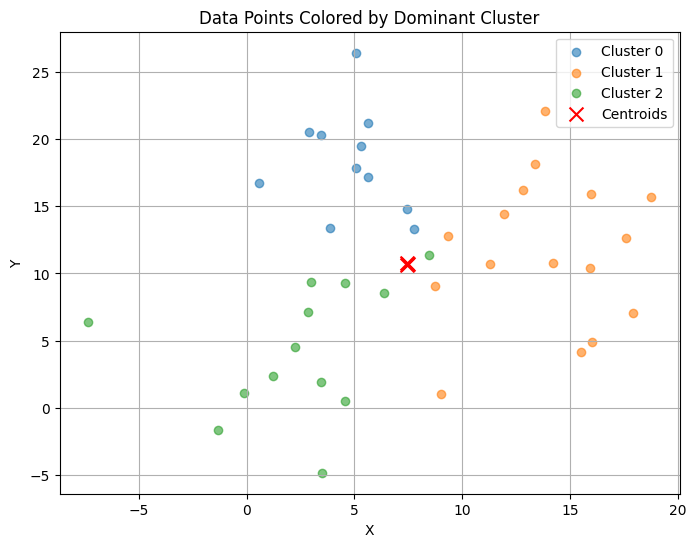

Normalized Mutual Information (NMI): 0.7040313737239762


In [167]:
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.metrics import normalized_mutual_info_score



num_clusters = 3
num_samples = 40

# Generate synthetic data with clusters
X, y = make_blobs(n_samples=num_samples, centers=num_clusters, cluster_std=4, random_state=42)
X += 10



# Visualize the generated data
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='viridis', s=20)
plt.title('Synthetic Data for Clustering')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()


centroids ,membership_mat = fuzzy_cmeans(data=X, num_clusters=num_clusters, max_iter=20, epsilon=1, m=1.1, y=y)

max_membership_cluster = np.argmax(membership_mat, axis=0)
# Plot data points with colors based on their corresponding centroids
plt.figure(figsize=(8, 6))
for i in range(num_clusters):
    cluster_data = X[max_membership_cluster == i]
    plt.scatter(cluster_data[:, 0], cluster_data[:, 1], label=f'Cluster {i}', alpha=0.6)
plt.scatter(centroids[:, 0], centroids[:, 1], c='red', marker='x', s=100, label='Centroids')
plt.title('Data Points Colored by Dominant Cluster')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.grid(True)
plt.show()
# Assuming 'y' contains the true cluster labels and 'max_membership_cluster' contains the cluster labels assigned by your fuzzy clustering algorithm
nmi = normalized_mutual_info_score(y, max_membership_cluster)
print("Normalized Mutual Information (NMI):", nmi)